In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pydicom
import os
from glob import glob
import h5py
import utils_io as u
import torchvision
import torch
from PIL import Image
from torch.utils.data import DataLoader
from matplotlib.backends.backend_pdf import PdfPages
from model import ESPCN
from utils_model import get_inference_slice

cwd = os.path.dirname(os.path.abspath('prototype.ipynb')) # current working directory

In [2]:
def plot(x_true, x_blur, x_out=None, save_pdf=False):
    '''Plot either two or three images for Tasks II, III respectively'''
    try: # determine whether x_out was entered
        im3 = x_out.any()
    except AttributeError:
        im3 = x_out
    
    num_imgs = 2 if im3 == None else 3
    fig, ax = plt.subplots(1, num_imgs, figsize=[12,12])
    
    imgs = [x_true, x_blur, x_out]
    titles = ['Ground Truth', 'Blurred', 'DL Result']
    
    for i in range(num_imgs):
        ax[i].imshow(imgs[i], cmap='gray')
        #ax[i].set_title(titles[i]) # uncomment for titles
        ax[i].axis('off')
    
    if save_pdf:
        pdf_fn = 'blurred.pdf' if im3 == None else 'dl_result.pdf'
        pdf = PdfPages(pdf_fn)
        pdf.savefig(bbox_inches='tight')
        pdf.close()
    
    plt.show()
    
def to_np(a):
    '''Given 4D torch tensor, output 2D numpy array'''
    return a.numpy()[0][0]
    
def perform_inference():
    '''Run inference with trained model on Case 17 central slice
       Returns three images: ground truth, blurred, and model output'''
    net = ESPCN(2)
    weights = torch.load('data/weights/weights_epoch_30.pth')
    net.load_state_dict(weights)
    net.eval()

    infer_set = get_inference_slice(2)
    infer_data_loader = DataLoader(dataset=infer_set, num_workers=1, \
                       batch_size=1, shuffle=False)
    dtype=torch.FloatTensor
    for batch in infer_data_loader:
        im_in,target = batch[0].type(dtype), \
                       batch[1].type(dtype)
    pred = net(im_in)
    pred = torch.tensor(pred,requires_grad=False)
    
    return to_np(target), to_np(im_in), to_np(pred)

def get_middle_slice(path):
    '''Given directory of dicom files, return numpy array of middle slice'''
    vol = u.load_processed_scan(path)
    mid_slice = u.get_middle_slice(vol)
    return mid_slice

# Task II

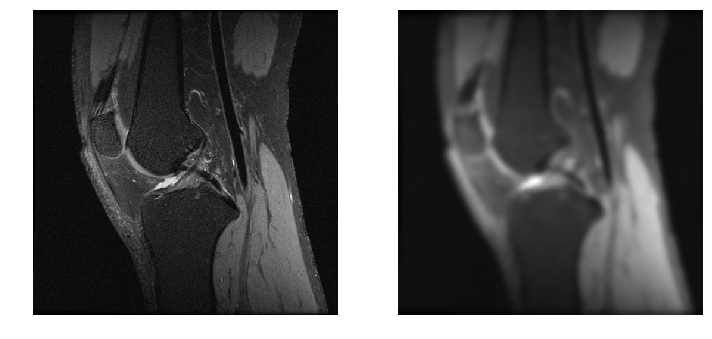

In [3]:
path_orig = 'data/output_dicom/P1_dcm_out/'
path_blur = 'data/blurred_dicom/P1_dcm_blur/'

slice_orig = get_middle_slice(path_orig)
slice_blur = get_middle_slice(path_blur)

plot(slice_orig, slice_blur)

# Task III

/home/dave/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


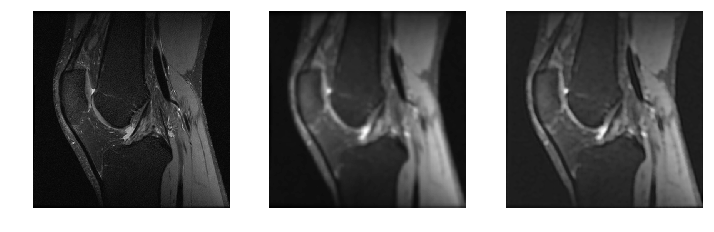

In [4]:
x_orig, x_blur, x_out = perform_inference()
plot(x_orig,x_blur,x_out)

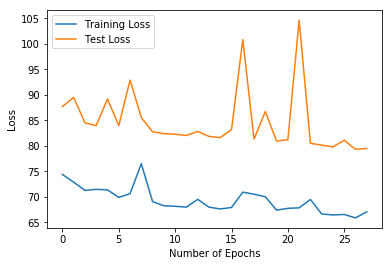

In [28]:
tr_loss = np.load('data/converg/train_loss.npy')
te_loss = np.load('data/converg/test_loss.npy')


plt.plot(range(len(tr_loss)), tr_loss, range(len(te_loss)), te_loss)
plt.legend(('Training Loss', 'Test Loss'))
# plt.title('Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

# pdf_fn = 'converg_curve.pdf'
# pdf = PdfPages(pdf_fn)
# pdf.savefig(bbox_inches='tight')
# pdf.close()